In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import cv2

pd.set_option('display.max_rows', None)  # Show all rows in output
pd.set_option('display.max_columns', None)  # (Optional) Show all columns for DataFrames

### Define number of threads

In [2]:
from joblib import parallel_backend

parallel_backend("threading", n_jobs=1)

## Loading Images

In [3]:
def load_images(dir:str):
    images_dict = {'id':[], 'image':[]}
    for id in os.listdir(dir):
        user_images = load_images_from_dir(dir + '/' + id)
        images_dict['id'] += [int(id.removeprefix('user'))]*len(user_images)
        images_dict['image'] += user_images
    
    return pd.DataFrame(images_dict)
    
def load_images_from_dir(dir):
    images = []
    for filename in os.listdir(dir):
        img = cv2.imread(os.path.join(dir,filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            images.append(img)
    return images

from typing import Optional
def display_image_grid(images, grid_size: Optional[tuple[int, int]] = None) -> None:
    """
    Displays a grid of images.
    
    :param images: List of images (as NumPy arrays, loaded using cv2.imread).
    :param grid_size: Optional tuple (rows, cols). If None, a square grid is created.
    """
    num_images = len(images)
    if grid_size is None:
        side = int(np.ceil(np.sqrt(num_images)))
        grid_size = (side, side)

    rows, cols = grid_size
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    axes = np.array(axes).flatten()
    if type(images) == pd.DataFrame or type(images) == pd.Series:
        images_idxs = images.index.tolist()
    else:
        images_idxs = list(range(len(images)))

    for idx, ax in enumerate(axes):
        if idx < num_images:
            ax.imshow(cv2.cvtColor(np.array(images[images_idxs[idx]]), cv2.COLOR_BGR2RGB))
            ax.axis('off')  # Hide axes for images
        else:
            ax.axis('off')  # Hide unused grid cells

    plt.tight_layout()
    plt.show()


## Preprocessing Functions

In [5]:

def preprocess_canny_image(image: np.ndarray):
    # Find thereshold's with Otsu method
    high_thresh, thresh_im = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    lowThresh = 0.5*high_thresh
    image = cv2.Canny(image, threshold1=lowThresh, threshold2=high_thresh)
    
    return image

def preprocess_binary_thershold_image(image: np.ndarray):
    high_thresh, thresh_im = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return thresh_im

def no_preprocess(image):
    return image

## Robustness testing functions

In [6]:
def scale_transform(image, scale):
    height, width = image.shape[:2]
    scaled_image = cv2.resize(image, (int(width * scale), int(height * scale)))
    return scaled_image

def rotation_transform(image, angle):
    height, width = image.shape[:2]
    center = (width // 2, height // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height))
    return rotated_image

def illumination_tranform(image, alpha, beta=0):
    brightened_image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return brightened_image

def gaussian_noise_transform(image, sigma, mean=0):
    noise = np.random.normal(mean, sigma, image.shape).astype(np.uint8)
    noisy_image = cv2.add(image, noise)
    return noisy_image

def box_blur_transform(image, ksize = 3):
    return cv2.blur(image, ksize)

def gaussian_blur_transform(image, sigma):
    return cv2.GaussianBlur(image, (41, 41), sigma)



## Plotting Functions (Bar Plots and Heatmap)

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def barplot_time_features(df):
   
    # Bar plot for number of features
    plt.figure(figsize=(10, 6))
    sns.barplot(x="descriptors", y="avg_features", data=df, palette="viridis")
    plt.title("Average Number of Features Extracted by Descriptor Type")
    plt.xlabel("Descriptor Type")
    plt.ylabel("Average Number of Features")
    plt.show()

    # Bar plot for time taken
    plt.figure(figsize=(8, 5))
    sns.barplot(x="descriptors", y="descriptors_time", data=df, palette="plasma")
    plt.title("Time Taken by Descriptor Type")
    plt.xlabel("Descriptor Type")
    plt.ylabel("Time (s)")
    plt.show()

def barplot_accuracy(df):
    # Bar plot for accuracy
    plt.figure(figsize=(8, 5))
    sns.barplot(x="descriptors", y="accuracy", hue="classifier", data=df, palette="coolwarm")
    plt.title("Accuracy by Descriptor")
    plt.xlabel("Descriptor Type")
    plt.ylabel("Accuracy")
    plt.ylim(0, 1)
    plt.legend(title="Classifier")
    plt.show()

def barplot_accuracy_clusters(df):
    # Bar plot for accuracy with clusters
    plt.figure(figsize=(8, 5))
    sns.barplot(x="descriptors", y="accuracy",  hue="num_of_clusters", data=df, palette="coolwarm")
    plt.title("Accuracy by Descriptor and Number of Clusters")
    plt.xlabel("Descriptor Type")
    plt.ylabel("Accuracy")
    plt.ylim(0, 1)
    plt.legend(title="Number of Clusters")
    plt.show()

def plot_mean_accuracy_by_transformation(df_accuracy):
    df_accuracy["transformation"] = df_accuracy["test_set"].str.extract(r'(\D+)_', expand=False)

    # Group by transformation to calculate average accuracy
    transformation_group = df_accuracy.groupby(["transformation", "descriptors"]).accuracy.mean().reset_index()

    # Bar plot for accuracy by transformation
    plt.figure(figsize=(10, 6))
    sns.barplot(x="transformation", y="accuracy", hue="descriptors", data=transformation_group, palette="viridis")
    plt.title("Accuracy by Transformation Type")
    plt.xlabel("Transformation Type")
    plt.ylabel("Mean Accuracy")
    plt.xticks(rotation=45)
    plt.ylim(0, 1)
    plt.legend(title="Descriptor")
    plt.show()

def plot_accuracy_heatmap(df_accuracy):
    
    df_accuracy_copy = df_accuracy

    df_accuracy_copy['accuracy'] = pd.to_numeric(df_accuracy_copy['accuracy'], errors='coerce')

    df_accuracy_cleaned = df_accuracy_copy.groupby(['test_set', 'descriptors'], as_index=False).mean(numeric_only=True)

    pivot_df = df_accuracy_cleaned.pivot(index='test_set', columns='descriptors', values='accuracy')

    # Plot the heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot_df, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
    plt.title("Accuracy Heatmap")
    plt.xlabel("Descriptors")
    plt.ylabel("Test Sets")
    plt.show()

# **Main Class for any type of descriptors to fit and predict**

In [10]:
from enum import Enum
from typing import Callable
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import accuracy_score
from collections import namedtuple
from contextlib import contextmanager
from sklearn.preprocessing import StandardScaler

import time

# Execution time for each type of operation
exec_time = namedtuple('excecusion_time', ['preprocessing', 'descriptors', 'clustering', 'clf_training'])
# Statistics (keypoints_total, keypoints_avg) extracted from images by the feature detector
Stats = namedtuple('Stats', ['keypoints_total', 'keypoints_avg', ])

class Timer:
    def __init__(self):
        self.start_time = None
        self.end_time = None
        self.timings = []

    def start(self):
        self.start_time = time.perf_counter()

    def stop(self):
        self.end_time = time.perf_counter()
        self.timings.append((self.end_time - self.start_time))

    def get_timings(self):
        return self.timings
    
    def clear(self):
        self.timings = []

class ImageClassifier:
    
    def __init__(self, feature_detector:object, classifier:object, preprocess_image:Callable[[np.ndarray], np.ndarray], verbose=0, vocab_scale = 1000):
        if not callable(preprocess_image):
            raise TypeError("preprocess_image must be a callable.")

        if not hasattr(classifier, "fit") or not hasattr(classifier, "predict"):
            raise TypeError("The classifier must implement 'fit' and 'predict' methods.")

        if not hasattr(feature_detector, "detectAndCompute"):
            raise TypeError("The feature_detector must implement 'detectAndCompute' method.")

        self.feature_detector = feature_detector
        self.classifier = classifier
        self.preprocess_image = preprocess_image
        self.verbose = verbose
        self.vocab_scale = vocab_scale
        self.scaler = StandardScaler()
        self.timer = Timer()

    def fit(self, images, y):
        assert images.shape[0] == y.shape[0]

        self.log('Preprocessing images...')
        self.timer.start()        
        images = self.preprocess_images(images)
        self.timer.stop()
        # find descriptors per image
        self.log(self.timer.get_timings()[-1])
        self.log('Calculating descriptors...')

        self.timer.start()        
        descriptors_list = self.get_descriptors_list(images)
        self.timer.stop()        

        self.log(self.timer.get_timings()[-1])

        self.log('Clustering descriptors')
        self.timer.start()        
        # combine descriptors into one long array (not per image) for clustering
        descriptors_all = np.concatenate(descriptors_list, axis=0)
        self.kmeans = self.train_kmeans(descriptors_all, vocab_scale=self.vocab_scale)
        self.timer.stop()

        self.log(self.timer.get_timings()[-1])

        self.log('Training Model')
        

        self.timer.start()
        
        X = self.get_feature_matrix(descriptors_list)
        X = self.scaler.fit_transform(X)
        self.train_model(X, y)
        self.timer.stop()        
        self.log(self.timer.get_timings()[-1])


        self._stats = Stats(descriptors_all.shape[0], descriptors_all.shape[0]/len(descriptors_list))
        return self
    
    def predict(self, images):
        images = self.preprocess_images(images)
        descriptors_list = self.get_descriptors_list(images)
        X = self.get_feature_matrix(descriptors_list)
        X = self.scaler.transform(X)
        return self.classifier.predict(X)
    
    def preprocess_images(self, images):
        return  [self.preprocess_image(x) for x in images]

    def get_descriptors(self, img):
        keypoints, descriptors = self.feature_detector.detectAndCompute(img, None)
        return descriptors
    
    def get_descriptors_list(self, images):
        return [self.get_descriptors(img) for img in images]

    def train_kmeans(self, descriptors, vocab_scale):
        k_means = MiniBatchKMeans(n_clusters=int(vocab_scale))
        k_means.fit(descriptors)
        return k_means
    
    def get_feature_matrix(self, descriptors_list):
        # Returns BOW vector
        feature_vec = np.zeros((len(descriptors_list), self.kmeans.n_clusters))
        for img_idx, descriptors in enumerate(descriptors_list):
                if descriptors is None or descriptors[0] is None:
                    continue
                clusters = self.kmeans.predict(descriptors)
                np.add.at(feature_vec[img_idx], clusters, 1)

        return feature_vec

    def train_model(self, X, y):
        self.classifier.fit(X, y)
    
    def log(self, message):
        if self.verbose == 1:
            print(message)
    
    def get_excecusion_time(self):
        return exec_time(*self.timer.get_timings())

    
    def get_stats(self):
        if not hasattr(self, '_stats'):
            raise TypeError("You need to run fit first.")
        
        return self._stats

## Function to predict and evaluate the accuracy of the model

In [11]:
def make_prediction_and_evaluation(image_classifier, images_test, y_test):
    y_pred = image_classifier.predict(images_test)
    stats = image_classifier.get_stats()
    keypoints_total = stats.keypoints_total
    keypoints_avg = stats.keypoints_avg

    print(f"Total keypoints: {keypoints_total}")
    print(f"Average keypoints: {keypoints_avg}")

    # Get Descriptors time
    descriptors_time = image_classifier.get_excecusion_time().descriptors

    print(f"Descriptors time: {descriptors_time}")
    

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Acuuracy: {accuracy}")

    return y_pred

# Program

## Loading images

In [12]:
df_images = load_images('isolated_words_per_user')

## Splitting the dataset and defining transformations values

In [13]:

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

images_train, images_test, y_train, y_test = train_test_split(df_images['image'], df_images['id'], train_size=0.8)

def apply_transformations(images, transformations):
    transformed_images = {}
    
    transform_functions = {
        "scale": scale_transform,
        "rotation": rotation_transform,
        "illumination": illumination_tranform,
        "gaussian_noise": gaussian_noise_transform,
        "gaussian_blur": gaussian_blur_transform
    }

    for transformation_name, params in transformations.items():
        for param in params:
            key = f"{transformation_name}_{param}"
            transformed_images[key] = []
            for img in images:
                transformed_image = transform_functions[transformation_name](img, param)
                transformed_images[key].append(transformed_image)
    
    return transformed_images

transformations = {
    "scale": [0.8, 1.2],
    "rotation": [-30, -60, -90, 30, 60, 90],
    "illumination": [0.1, 0.5, 1.5, 1.9],  # Darken and brighten
    "gaussian_noise": [25, 50, 100],
    "gaussian_blur": [25, 50, 100]
}

images_test_dict = apply_transformations(images_test, transformations)


## Defining two data frames one for original test set and another one for transformed test set

In [14]:
df_accuracy = pd.DataFrame(columns=['classifier', 'descriptors', 'num_of_clusters', 'test_set', 'avg_features', 'descriptors_time', 'accuracy'])
df_accuracy_original_test = pd.DataFrame(columns=['classifier', 'descriptors', 'num_of_clusters', 'avg_features', 'descriptors_time', 'accuracy'])

# **Extract keypoints**


# Random Forest Classifier

## SIFT Training

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier()

parameters = {'n_estimators':[1000]}
clf = GridSearchCV(rf, parameters)
sift = cv2.SIFT_create()
image_classifier = ImageClassifier(feature_detector=sift, classifier=clf, preprocess_image=no_preprocess, verbose=1, vocab_scale=1000)
image_classifier.fit(images_train, y_train)

Preprocessing images...
0.000832499994430691
Calculating descriptors...
17.298002799972892
Clustering descriptors
3.7254321000073105
Training Model
208.41772430000128


## SIFT Prediction and Evaluation

In [16]:
# Predict and Evaluate Accuracy
y_pred = make_prediction_and_evaluation(image_classifier, images_test, y_test)

stats = image_classifier.get_stats()
keypoints_avg = stats.keypoints_avg

# Get Descriptors time
descriptors_time = image_classifier.get_excecusion_time().descriptors
ac = accuracy_score(y_test, y_pred)
df_accuracy_original_test.loc[len(df_accuracy_original_test)] = ['rf' + str(clf.best_params_), 'sift', 1000, keypoints_avg, descriptors_time, ac]

Total keypoints: 595208
Average keypoints: 91.35963161933998
Descriptors time: 17.298002799972892
Acuuracy: 0.2823818293431553


C:\Users\qusay\AppData\Local\Temp\ipykernel_632\1969357426.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="descriptors", y="avg_features", data=df, palette="viridis")


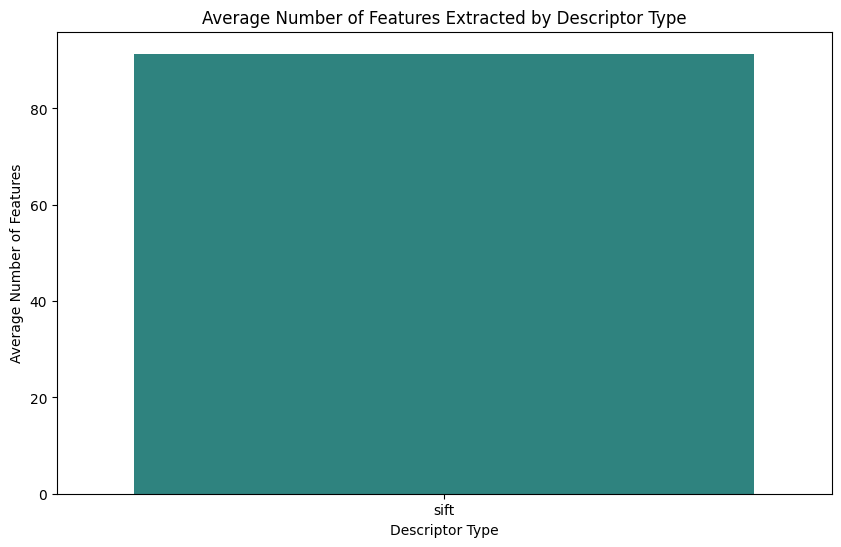

C:\Users\qusay\AppData\Local\Temp\ipykernel_632\1969357426.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="descriptors", y="descriptors_time", data=df, palette="plasma")


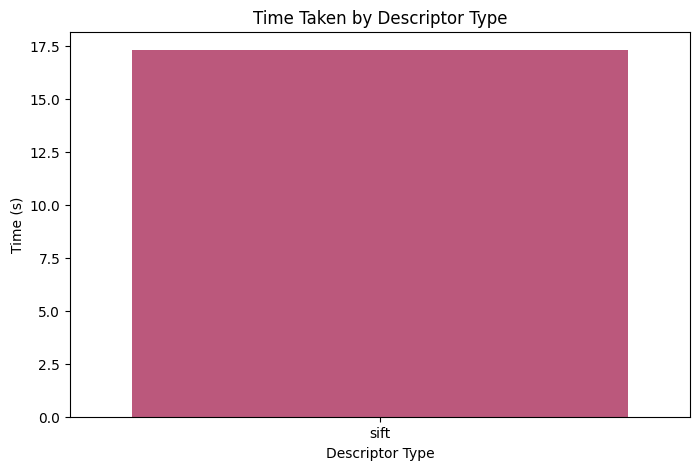

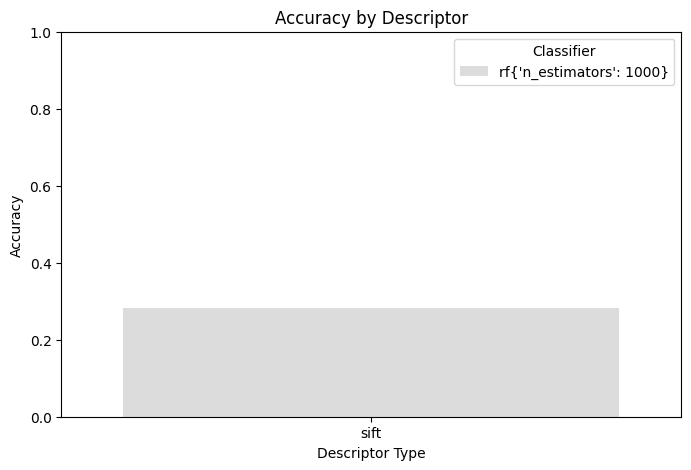

In [21]:
barplot_time_features(df_accuracy_original_test)
barplot_accuracy(df_accuracy_original_test)

In [18]:

clf.best_estimator_

RandomForestClassifier(n_estimators=1000)

## ORB Training

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier()

parameters = {'n_estimators':[1000]}
clf = GridSearchCV(rf, parameters)
orb = cv2.ORB_create()
image_classifier = ImageClassifier(feature_detector=orb, classifier=clf, preprocess_image=no_preprocess, verbose=1)
image_classifier.fit(images_train, y_train)

Preprocessing images...
0.0023439000360667706
Calculating descriptors...
4.955732500005979
Clustering descriptors
6.233436900016386
Training Model
289.5436760999728


## ORB Prediction and Evaluation

In [23]:
# Predict and Evaluate Accuracy
y_pred = make_prediction_and_evaluation(image_classifier, images_test, y_test)

stats = image_classifier.get_stats()
keypoints_avg = stats.keypoints_avg

# Get Descriptors time
descriptors_time = image_classifier.get_excecusion_time().descriptors
ac = accuracy_score(y_test, y_pred)
df_accuracy_original_test.loc[len(df_accuracy_original_test)] = ['rf' + str(clf.best_params_), 'orb', 1000, keypoints_avg, descriptors_time, ac]

Total keypoints: 1147874
Average keypoints: 176.18940905602457
Descriptors time: 4.955732500005979
Acuuracy: 0.1614487415592388


C:\Users\qusay\AppData\Local\Temp\ipykernel_632\1969357426.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="descriptors", y="avg_features", data=df, palette="viridis")


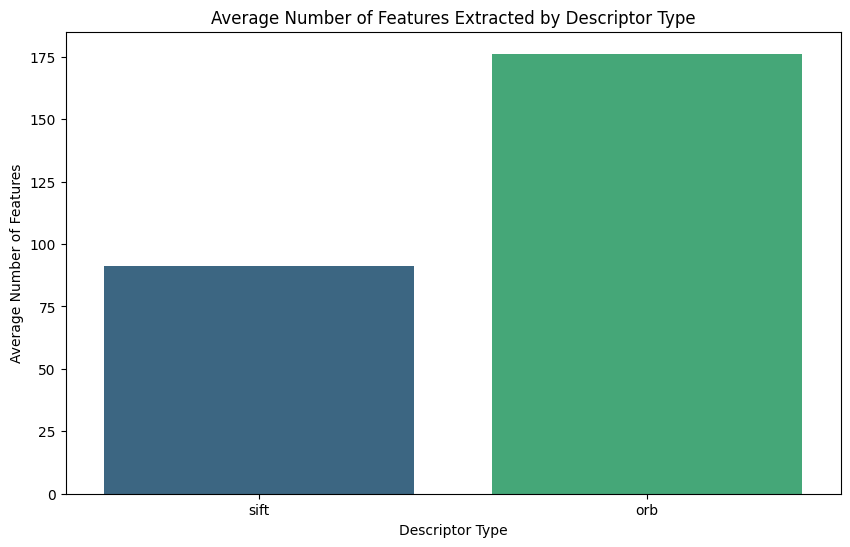

C:\Users\qusay\AppData\Local\Temp\ipykernel_632\1969357426.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="descriptors", y="descriptors_time", data=df, palette="plasma")


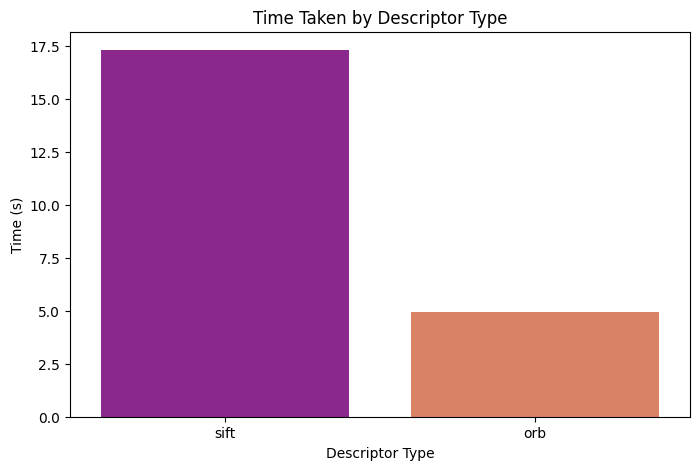

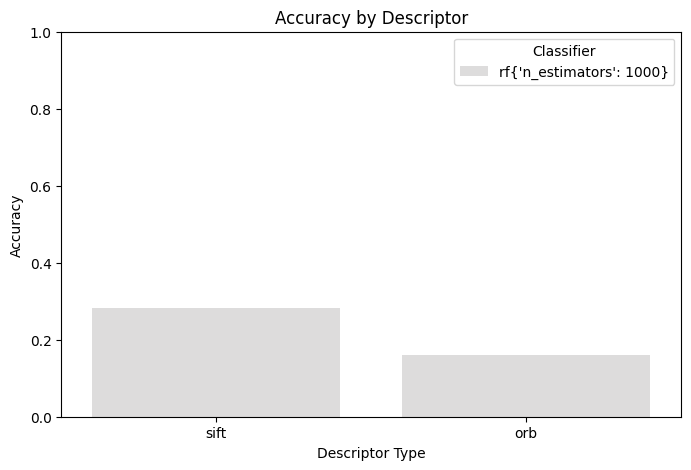

In [24]:
barplot_time_features(df_accuracy_original_test)
barplot_accuracy(df_accuracy_original_test)

In [25]:

clf.best_estimator_

RandomForestClassifier(n_estimators=1000)

## AKAZE Training

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier()

parameters = {'n_estimators':[1000]}
clf = GridSearchCV(rf, parameters)
akaze = cv2.AKAZE_create()
image_classifier = ImageClassifier(feature_detector=akaze, classifier=clf, preprocess_image=no_preprocess, verbose=1)
image_classifier.fit(images_train, y_train)

Preprocessing images...
0.1755350999883376
Calculating descriptors...
46.38124560000142
Clustering descriptors
2.9386530999909155
Training Model
264.7827767999843


## AKAZE Prediction and Evaluation

In [27]:
# Predict and Evaluate Accuracy
y_pred = make_prediction_and_evaluation(image_classifier, images_test, y_test)

stats = image_classifier.get_stats()
keypoints_avg = stats.keypoints_avg

# Get Descriptors time
descriptors_time = image_classifier.get_excecusion_time().descriptors
ac = accuracy_score(y_test, y_pred)
df_accuracy_original_test.loc[len(df_accuracy_original_test)] = ['rf' + str(clf.best_params_), 'akaze', 1000, keypoints_avg, descriptors_time, ac]

Total keypoints: 330603
Average keypoints: 50.744896392939374
Descriptors time: 46.38124560000142
Acuuracy: 0.1172498465316145


C:\Users\qusay\AppData\Local\Temp\ipykernel_632\1969357426.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="descriptors", y="avg_features", data=df, palette="viridis")


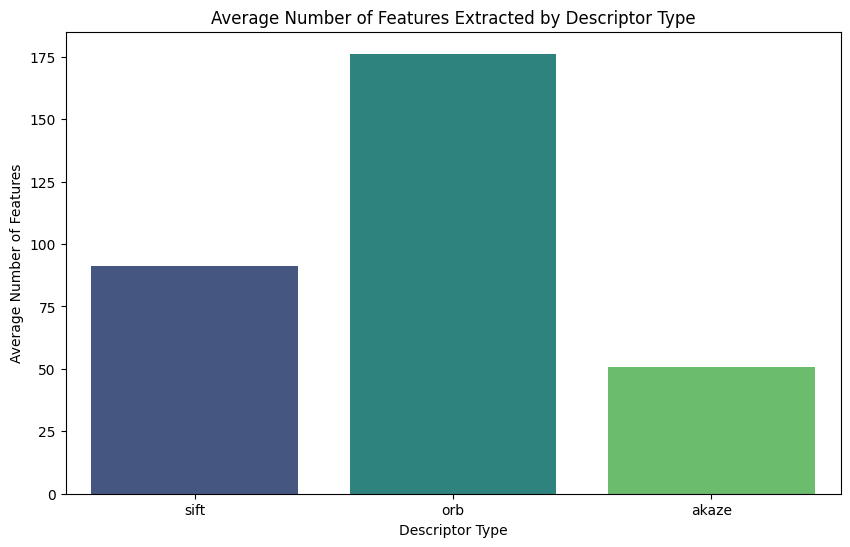

C:\Users\qusay\AppData\Local\Temp\ipykernel_632\1969357426.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="descriptors", y="descriptors_time", data=df, palette="plasma")


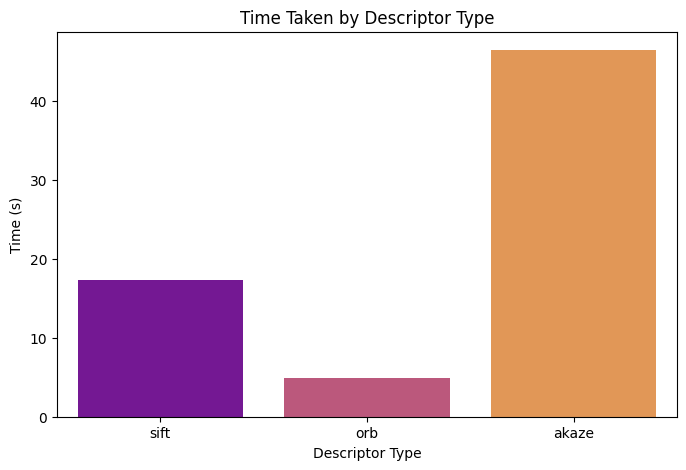

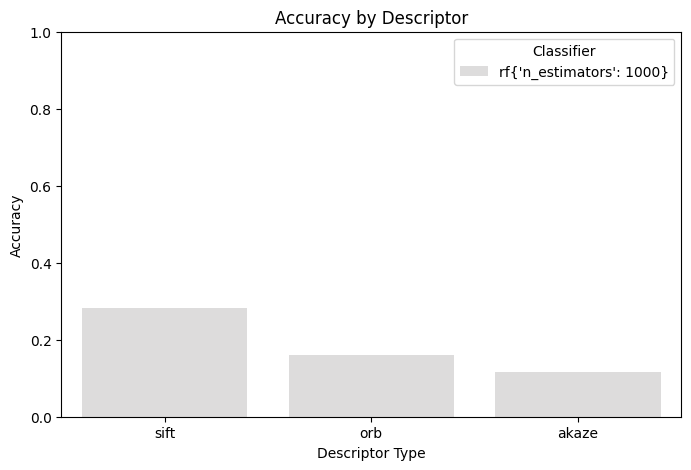

In [28]:
barplot_time_features(df_accuracy_original_test)
barplot_accuracy(df_accuracy_original_test)

In [29]:

clf.best_estimator_

RandomForestClassifier(n_estimators=1000)

# **SVM**

## SIFT Training

In [41]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV


parameters = {'kernel':['rbf'], 'C':[10]}
svc = SVC()
clf = GridSearchCV(svc, parameters, n_jobs=-1)
sift = cv2.SIFT_create()
num_of_clusters = 2000
image_classifier = ImageClassifier(feature_detector=sift, classifier=clf, preprocess_image=no_preprocess, verbose=1, vocab_scale=num_of_clusters)
image_classifier.fit(images_train, y_train)

Preprocessing images...
0.0009382000425830483
Calculating descriptors...
18.368842699972447
Clustering descriptors
19.35400240001036
Training Model
174.2665835999651


## SIFT Prediction and Evaluation

In [42]:
# Predict and Evaluate Accuracy
y_pred = make_prediction_and_evaluation(image_classifier, images_test, y_test)

stats = image_classifier.get_stats()
keypoints_avg = stats.keypoints_avg

# Get Descriptors time
descriptors_time = image_classifier.get_excecusion_time().descriptors
ac = accuracy_score(y_test, y_pred)
df_accuracy_original_test.loc[len(df_accuracy_original_test)] = ['rbf' + str(clf.best_params_), 'sift', num_of_clusters, keypoints_avg, descriptors_time, ac]

Total keypoints: 595208
Average keypoints: 91.35963161933998
Descriptors time: 18.368842699972447
Acuuracy: 0.34806629834254144


C:\Users\qusay\AppData\Local\Temp\ipykernel_632\1969357426.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="descriptors", y="avg_features", data=df, palette="viridis")


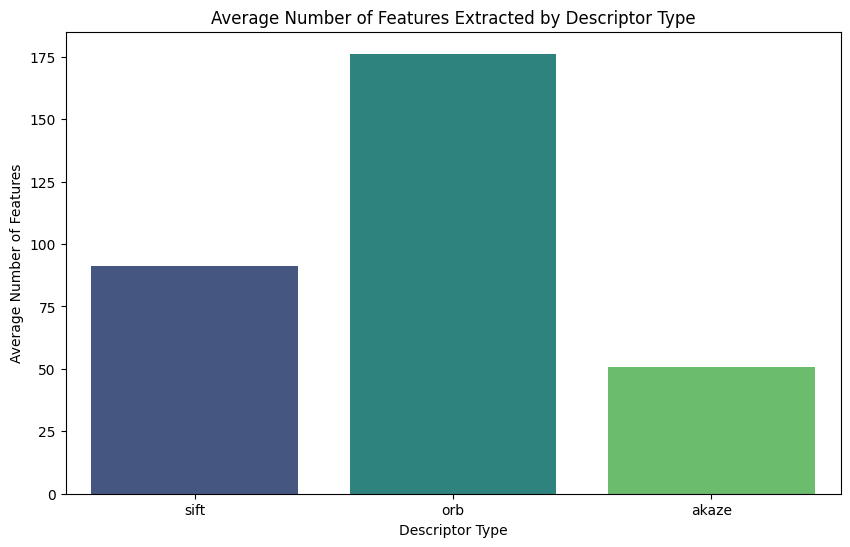

C:\Users\qusay\AppData\Local\Temp\ipykernel_632\1969357426.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="descriptors", y="descriptors_time", data=df, palette="plasma")


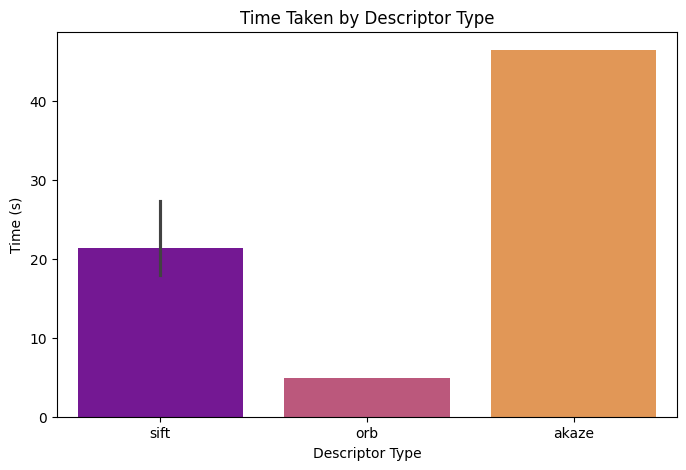

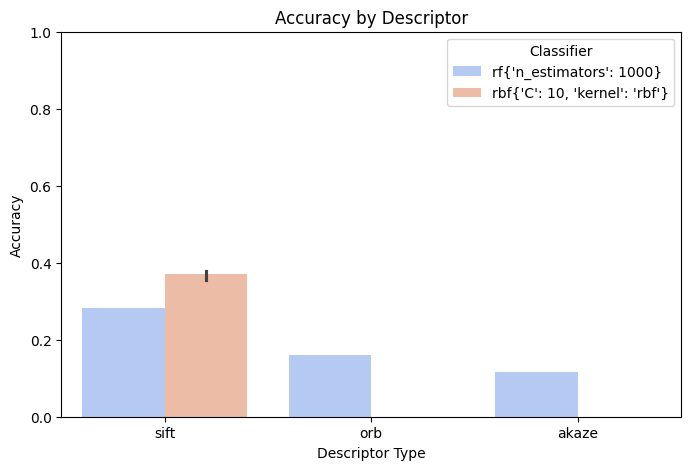

In [43]:
barplot_time_features(df_accuracy_original_test)
barplot_accuracy(df_accuracy_original_test)

In [44]:
clf.best_estimator_

SVC(C=10)

## ORB Training

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

parameters = {'kernel':['rbf'], 'C':[10]}
svc = SVC()
clf = GridSearchCV(svc, parameters)
orb = cv2.ORB_create()
num_of_clusters = 1000
image_classifier = ImageClassifier(feature_detector=orb, classifier=clf, preprocess_image=no_preprocess, verbose=1, vocab_scale=num_of_clusters)
image_classifier.fit(images_train, y_train)

Preprocessing images...
0.0008687000372447073
Calculating descriptors...
4.474781700002495
Clustering descriptors
18.838746900029946
Training Model
343.98724110005423


## ORB Prediction and Evaluation

In [58]:
# Predict and Evaluate Accuracy
y_pred = make_prediction_and_evaluation(image_classifier, images_test, y_test)

stats = image_classifier.get_stats()
keypoints_avg = stats.keypoints_avg

# Get Descriptors time
descriptors_time = image_classifier.get_excecusion_time().descriptors
ac = accuracy_score(y_test, y_pred)
df_accuracy_original_test.loc[len(df_accuracy_original_test)] = ['rbf' + str(clf.best_params_), 'orb', num_of_clusters, keypoints_avg, descriptors_time, ac]

Total keypoints: 1147874
Average keypoints: 176.18940905602457
Descriptors time: 4.474781700002495
Acuuracy: 0.2019643953345611


C:\Users\qusay\AppData\Local\Temp\ipykernel_632\1969357426.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="descriptors", y="avg_features", data=df, palette="viridis")


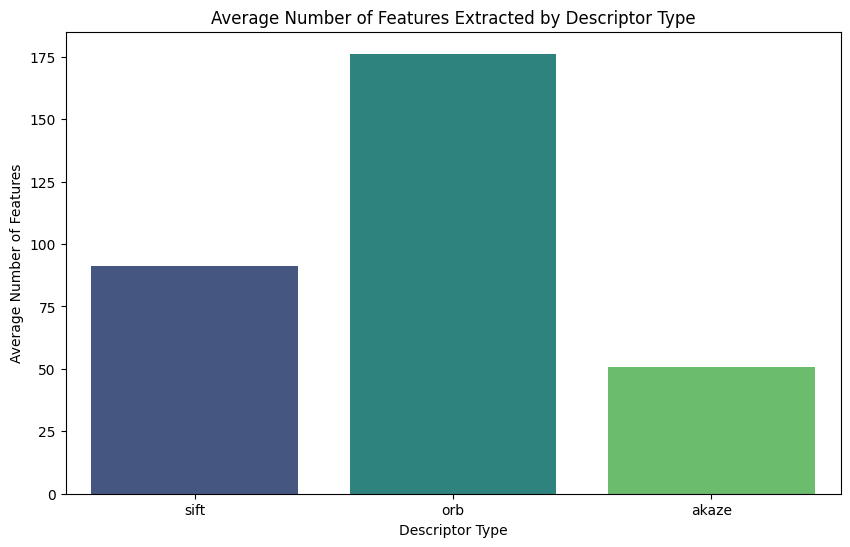

C:\Users\qusay\AppData\Local\Temp\ipykernel_632\1969357426.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="descriptors", y="descriptors_time", data=df, palette="plasma")


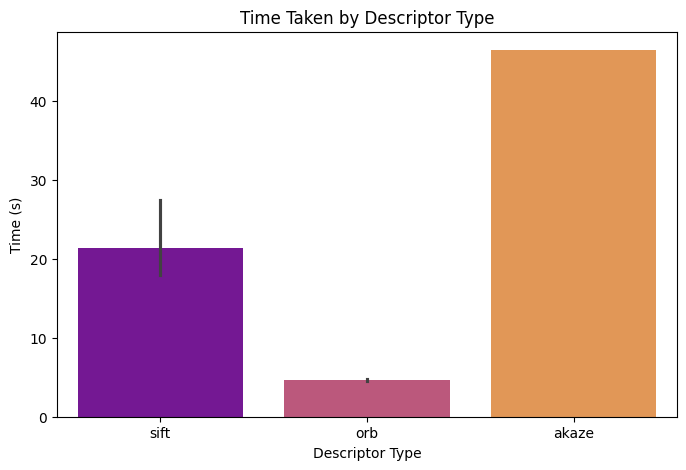

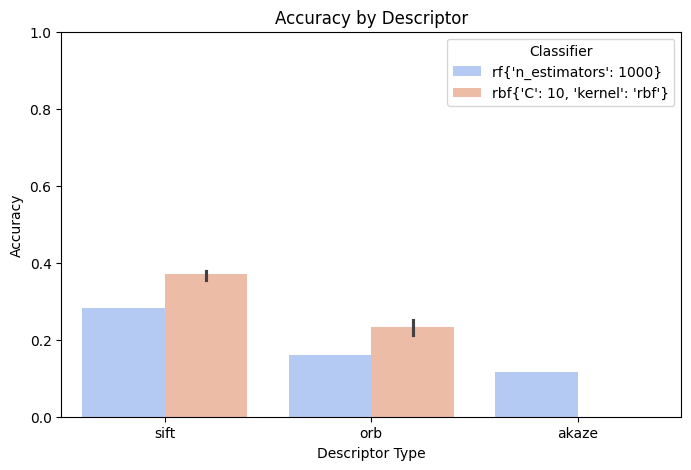

In [59]:
barplot_time_features(df_accuracy_original_test)
barplot_accuracy(df_accuracy_original_test)

In [48]:

clf.best_estimator_

SVC(C=10)

## AKAZE Training

In [70]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

parameters = {'kernel':['rbf'], 'C':[10]}
svc = SVC()
clf = GridSearchCV(svc, parameters)
akaze = cv2.AKAZE_create()
num_of_clusters = 1000
image_classifier = ImageClassifier(feature_detector=akaze, classifier=clf, preprocess_image=no_preprocess, verbose=1, vocab_scale=num_of_clusters)
image_classifier.fit(images_train, y_train)

Preprocessing images...
0.0009070999803952873
Calculating descriptors...
12.776865800027736
Clustering descriptors
9.91393139999127
Training Model
344.6916903000092


## AKAZE Prediction and Evaluation

In [71]:
# Predict and Evaluate Accuracy
y_pred = make_prediction_and_evaluation(image_classifier, images_test, y_test)

stats = image_classifier.get_stats()
keypoints_avg = stats.keypoints_avg

# Get Descriptors time
descriptors_time = image_classifier.get_excecusion_time().descriptors
ac = accuracy_score(y_test, y_pred)
df_accuracy_original_test.loc[len(df_accuracy_original_test)] = ['rbf' + str(clf.best_params_), 'akaze', num_of_clusters, keypoints_avg, descriptors_time, ac]

Total keypoints: 330603
Average keypoints: 50.744896392939374
Descriptors time: 12.776865800027736
Acuuracy: 0.13627992633517497


C:\Users\qusay\AppData\Local\Temp\ipykernel_632\1969357426.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="descriptors", y="avg_features", data=df, palette="viridis")


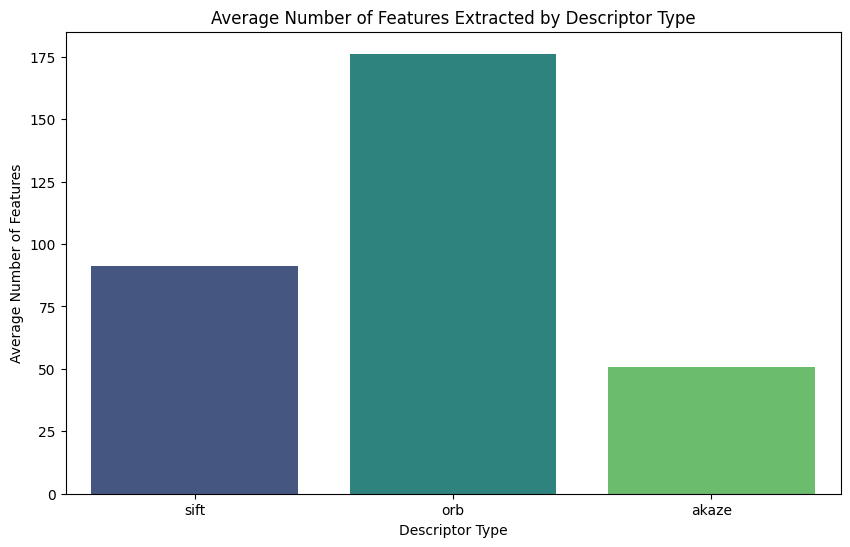

C:\Users\qusay\AppData\Local\Temp\ipykernel_632\1969357426.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="descriptors", y="descriptors_time", data=df, palette="plasma")


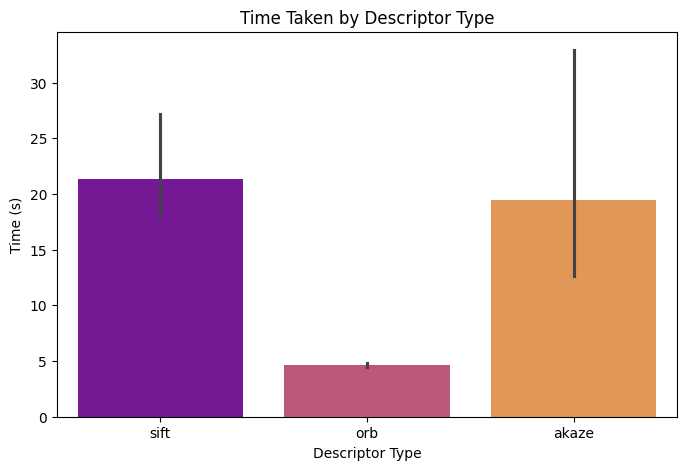

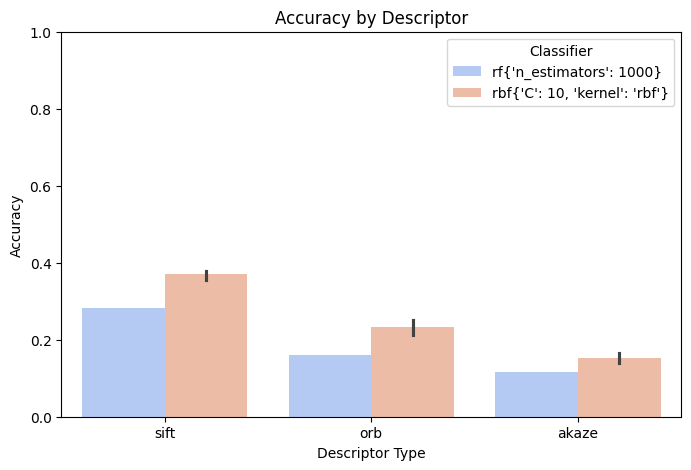

In [72]:
barplot_time_features(df_accuracy_original_test)
barplot_accuracy(df_accuracy_original_test)

## Accuracy of all types with multiple number of clusters

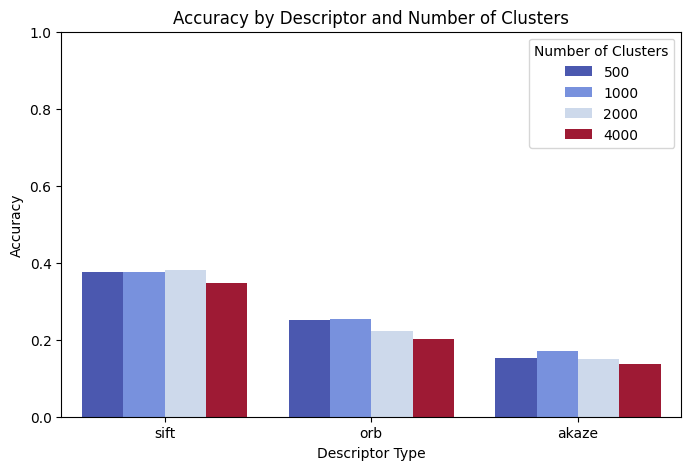

In [76]:
barplot_accuracy_clusters(df_accuracy_original_test[df_accuracy_original_test['classifier'] == "rbf{'C': 10, 'kernel': 'rbf'}" ])

In [66]:
clf.best_estimator_

SVC(C=10)

# Training Models with best hyperparameters

## SIFT Training with SVM

In [77]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV


parameters = {'kernel':['rbf'], 'C':[10]}
svc = SVC()
clf = GridSearchCV(svc, parameters, n_jobs=-1)
sift = cv2.SIFT_create()
num_of_clusters = 2000
image_classifier = ImageClassifier(feature_detector=sift, classifier=clf, preprocess_image=no_preprocess, verbose=1, vocab_scale=num_of_clusters)
image_classifier.fit(images_train, y_train)

Preprocessing images...
0.0019307999755255878
Calculating descriptors...
18.955228300008457
Clustering descriptors
6.678277699975297
Training Model
76.36453570000594


**SIFT Evaluation on Transformed Test Set**

In [78]:
# Make prediction on transformed images
for transformation_name in images_test_dict:
    y_pred = image_classifier.predict(images_test_dict[transformation_name])
    
    stats = image_classifier.get_stats()
    keypoints_avg = stats.keypoints_avg

    # Get execution times
    descriptors_time = image_classifier.get_excecusion_time().descriptors

    ac = accuracy_score(y_test, y_pred)

    df_accuracy.loc[len(df_accuracy)] = ['rbf' + str(clf.best_params_), 'sift', num_of_clusters, transformation_name, keypoints_avg, descriptors_time, ac]

## ORB Training with SVM

In [79]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

parameters = {'kernel':['rbf'], 'C':[10]}
svc = SVC()
clf = GridSearchCV(svc, parameters)
orb = cv2.ORB_create()
num_of_clusters = 1000
image_classifier = ImageClassifier(feature_detector=orb, classifier=clf, preprocess_image=no_preprocess, verbose=1, vocab_scale=num_of_clusters)
image_classifier.fit(images_train, y_train)

Preprocessing images...
0.0009003000450320542
Calculating descriptors...
4.513414699991699
Clustering descriptors
5.742167100019287
Training Model
77.73361659998773


**ORB Evaluation on Transformed Test Set**

In [80]:
# Make prediction on transformed images
for transformation_name in images_test_dict:
    y_pred = image_classifier.predict(images_test_dict[transformation_name])
    
    stats = image_classifier.get_stats()
    keypoints_avg = stats.keypoints_avg

    # Get execution times
    descriptors_time = image_classifier.get_excecusion_time().descriptors

    ac = accuracy_score(y_test, y_pred)

    df_accuracy.loc[len(df_accuracy)] = ['rbf' + str(clf.best_params_), 'orb', num_of_clusters, transformation_name, keypoints_avg, descriptors_time, ac]

## AKAZE Training with SVM

In [81]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

parameters = {'kernel':['rbf'], 'C':[10]}
svc = SVC()
clf = GridSearchCV(svc, parameters)
akaze = cv2.AKAZE_create()
num_of_clusters = 1000
image_classifier = ImageClassifier(feature_detector=akaze, classifier=clf, preprocess_image=no_preprocess, verbose=1, vocab_scale=num_of_clusters)
image_classifier.fit(images_train, y_train)

Preprocessing images...
0.0009052000241354108
Calculating descriptors...
12.76919059996726
Clustering descriptors
2.8958042999729514
Training Model
77.0342607999919


**AKAZE Evaluation on Transformed Test Set**

In [82]:
# Make prediction on transformed images
for transformation_name in images_test_dict:
    y_pred = image_classifier.predict(images_test_dict[transformation_name])
    
    stats = image_classifier.get_stats()
    keypoints_avg = stats.keypoints_avg

    # Get execution times
    descriptors_time = image_classifier.get_excecusion_time().descriptors

    ac = accuracy_score(y_test, y_pred)

    df_accuracy.loc[len(df_accuracy)] = ['rbf' + str(clf.best_params_), 'akaze', num_of_clusters, transformation_name, keypoints_avg, descriptors_time, ac]

# **Visualization**

## Features Detections

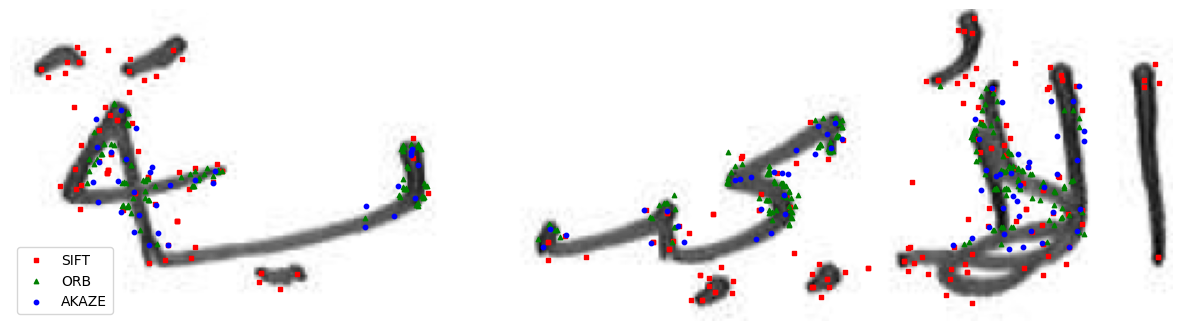

In [85]:
def detect_and_display_keypoints(img):

    # SIFT
    sift = cv2.SIFT_create()
    kp_sift, des_sift = sift.detectAndCompute(img, None)

    # ORB
    orb = cv2.ORB_create()
    kp_orb, des_orb = orb.detectAndCompute(img, None)

    # AKAZE
    akaze = cv2.AKAZE_create()
    kp_akaze, des_akaze = akaze.detectAndCompute(img, None)

    # Display the image with keypoints
    plt.figure(figsize=(15, 10))
    plt.imshow(img, cmap='gray')

    # Plot SIFT keypoints as squares
    plt.scatter([kp.pt[0] for kp in kp_sift], [kp.pt[1] for kp in kp_sift],
                s=10, color='red', marker='s', label='SIFT')

    # Plot ORB keypoints as triangles
    plt.scatter([kp.pt[0] for kp in kp_orb], [kp.pt[1] for kp in kp_orb],
                s=10, color='green', marker='^', label='ORB')

    # Plot AKAZE keypoints as circles
    plt.scatter([kp.pt[0] for kp in kp_akaze], [kp.pt[1] for kp in kp_akaze],
                s=10, color='blue', marker='o', label='AKAZE')

    plt.legend()
    plt.axis('off')
    plt.show()

detect_and_display_keypoints(df_images['image'][0])

## Plotting Evaluation Results on Normal Test Set

C:\Users\qusay\AppData\Local\Temp\ipykernel_632\3327448750.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="descriptors", y="avg_features", data=df, palette="viridis")


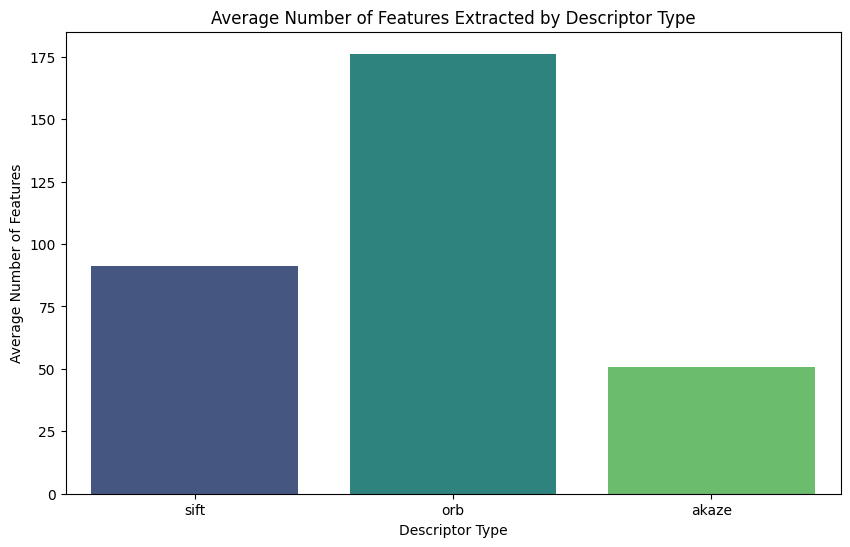

C:\Users\qusay\AppData\Local\Temp\ipykernel_632\3327448750.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="descriptors", y="descriptors_time", data=df, palette="plasma")


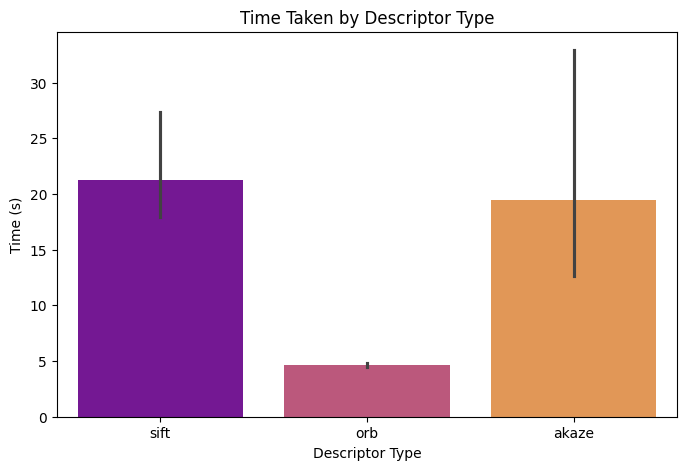

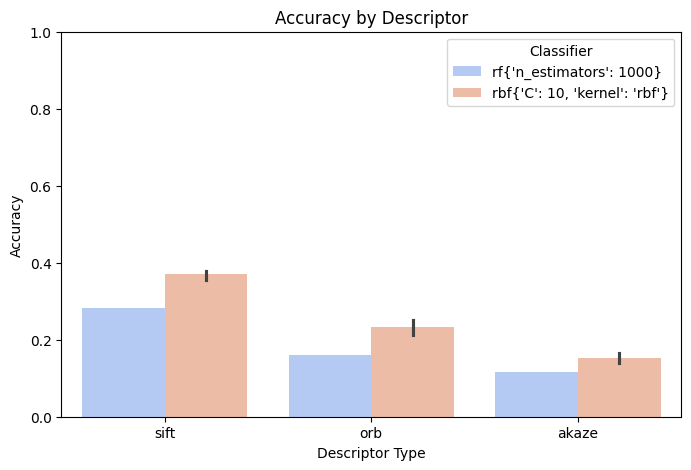

In [86]:
# Plot on normal test set
barplot_time_features(df_accuracy_original_test)
barplot_accuracy(df_accuracy_original_test)

## Plotting Evaluation Results on Transformed Test Set

C:\Users\qusay\AppData\Local\Temp\ipykernel_632\3327448750.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="descriptors", y="avg_features", data=df, palette="viridis")


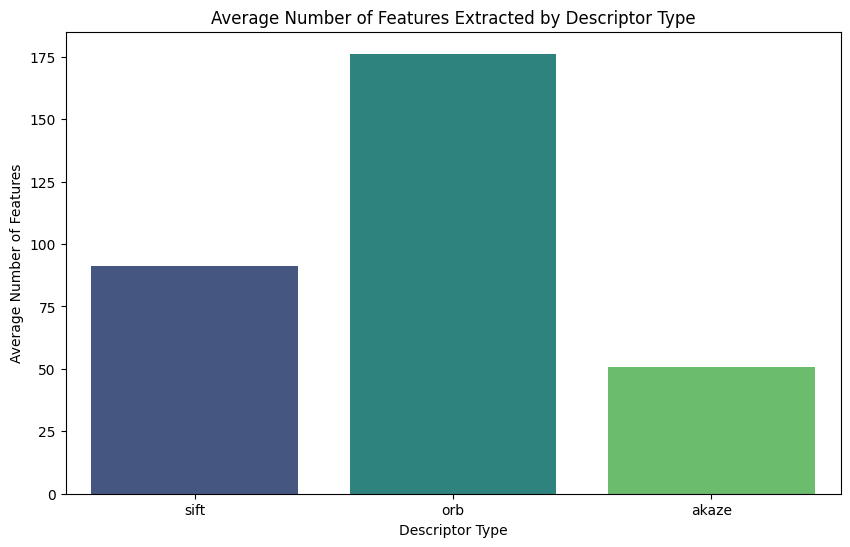

C:\Users\qusay\AppData\Local\Temp\ipykernel_632\3327448750.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="descriptors", y="descriptors_time", data=df, palette="plasma")


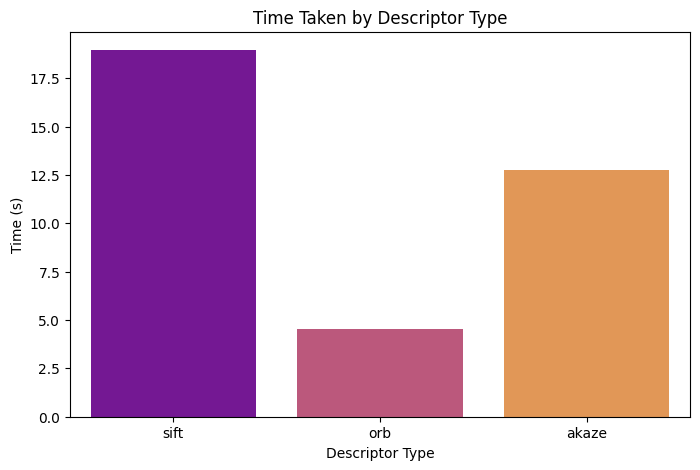

In [87]:
# Plot on transformed test set
barplot_time_features(df_accuracy)

## Plotting Mean Accuracy With Different Transformation Type

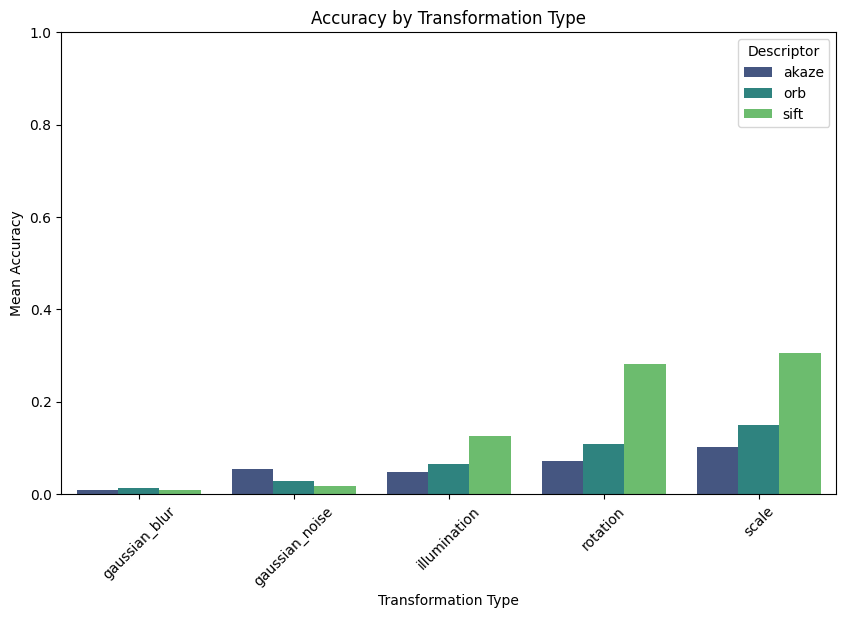

In [91]:
plot_mean_accuracy_by_transformation(df_accuracy)

## **Plotting Accuracy Heatmap** that shows the **accuracy** through different **transformation** types and **descriptors** type

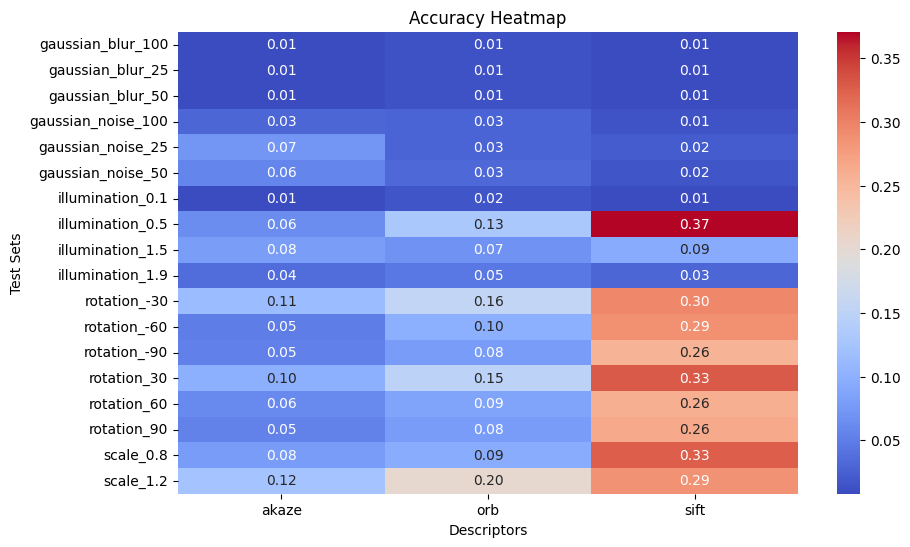

In [92]:
plot_accuracy_heatmap(df_accuracy)

## Plotting Instance of Transformed Images with different type of transformation

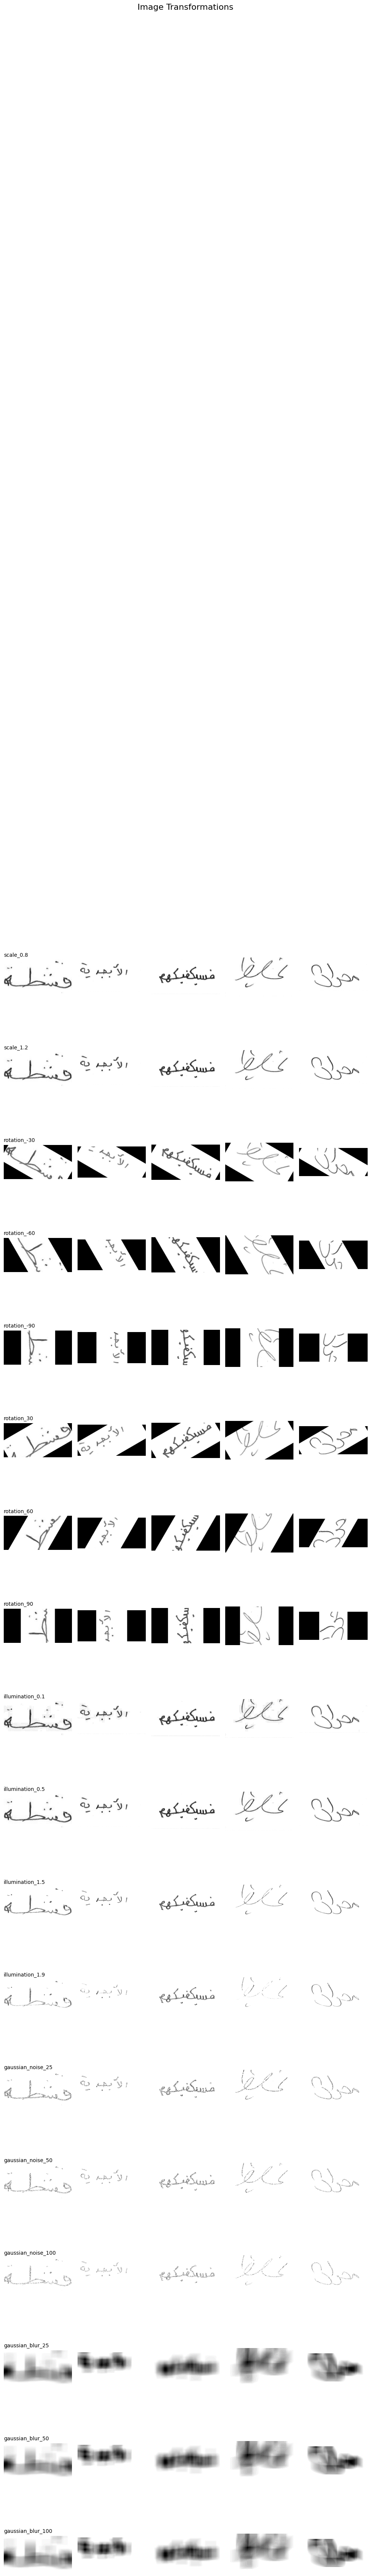

In [93]:
import matplotlib.pyplot as plt

def display_image_grid(images_test_dict, num_images=5):
    transformation_keys = list(images_test_dict.keys())

    num_images = min(num_images, len(images_test_dict[transformation_keys[0]]))

    num_transformations = len(transformation_keys)

    fig, axes = plt.subplots(
        num_transformations,
        num_images,
        figsize=(10, 5 * num_transformations),
        squeeze=False
    )
    
    
    plt.subplots_adjust(hspace=-0.97, wspace=0.1)

    fig.suptitle("Image Transformations", fontsize=16, y=1.02)

    for row, transformation_key in enumerate(transformation_keys):
        for col in range(num_images):
            ax = axes[row, col]
            ax.imshow(images_test_dict[transformation_key][col], cmap='gray')
            ax.axis('off')
            if col == 0: 
                ax.set_title(transformation_key, fontsize=10, loc='left')
    
    plt.tight_layout()
    plt.show()

# Display the grid
display_image_grid(images_test_dict, num_images=5)
